In [1]:
import os
import numpy as np


def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)

In [2]:


def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size
#try finding for class imbalance and use data agumentation ---if used any pretrainde as backbone use preprocessing step 

In [3]:
train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)

In [4]:
batch_size = 2
import random

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

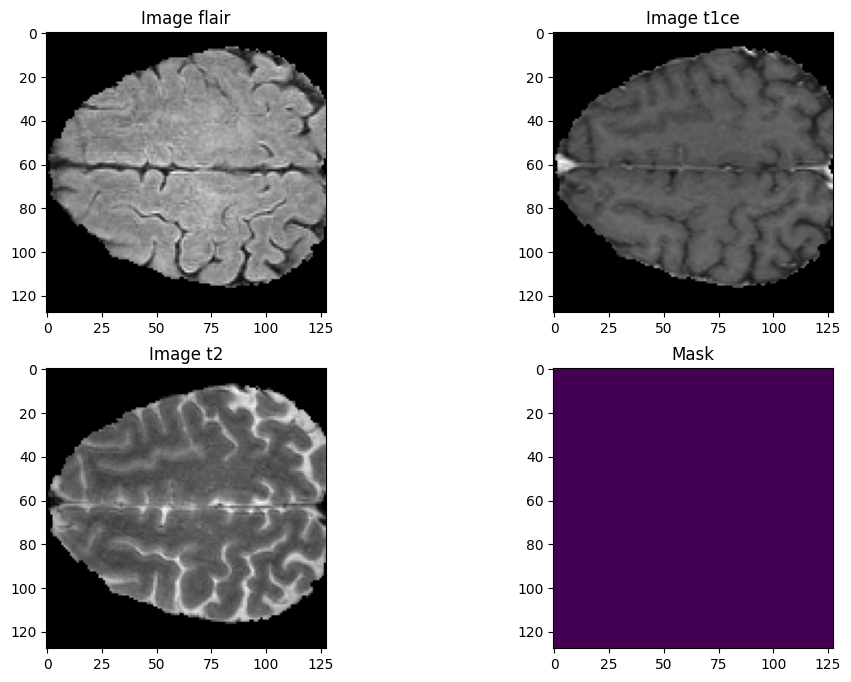

In [5]:
import matplotlib.pyplot as plt
n_slice=random.randint(0, test_mask.shape[2])
plt.figure(figsize=(12, 8))

plt.subplot(221)
plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
plt.title('Image flair')
plt.subplot(222)
plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
plt.title('Image t1ce')
plt.subplot(223)
plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
plt.title('Image t2')
plt.subplot(224)
plt.imshow(test_mask[:,:,n_slice])
plt.title('Mask')
plt.show()

In [1]:
import segmentation_models_3D as sm
from keras.optimizers import Adam
from keras.losses import CategoricalCrossentropy
from keras.metrics import MeanIoU
from keras.models import Model


2024-11-21 08:59:51.177544: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-21 08:59:51.604473: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-21 08:59:51.787502: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-21 08:59:51.838120: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-21 08:59:52.174179: I tensorflow/core/platform/cpu_feature_guar

Segmentation Models: using `keras` framework.


In [4]:
import segmentation_models_3D as sm
from tensorflow.keras.optimizers import Adam

# Define the model
model = sm.Unet(
    backbone_name='mobilenetv2',  
    input_shape=(128, 128, 128, 3),  # Input shape (H, W, D, Channels)
    encoder_weights='imagenet',  # No pre-trained weights for 3D MRI
    classes=4,  # 4 classes: Background, Edema, Non-enhancing tumor, Enhancing tumor
    activation='softmax'  # Multi-class segmentation
)

In [8]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_pad           │ (None, 129, 129,  │          0 │ input_layer[0][0] │
│ (ZeroPadding3D)     │ 129, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv3D)      │ (None, 64, 64,    │      2,592 │ Conv1_pad[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        864 │ Conv1_relu[0][0]  │
│ (DepthwiseConv3D)   │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv3D)            │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv3D)            │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding3D)     │ 65, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │      2,592 │ block_1_pad[0][0] │
│ (DepthwiseConv3D)   │ 32, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 32, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis

 Total params: 19,749,892 (75.34 MB)

 Trainable params: 19,713,796 (75.20 MB)

 Non-trainable params: 36,096 (141.00 KB)

In [9]:
# # from keras.utils.vis_utils import plot_model
# from tensorflow.keras.utils import plot_model


# # Plot Model Architecture
# plot_model(model, to_file='unet_resnet34_brats.png', show_shapes=True, expand_nested=True)

In [10]:
import tensorflow as tf

def dice_coefficient(y_true, y_pred, threshold=0.5, smooth=1e-6):
    """
    Calculate Dice coefficient for 3D segmentation.
     
    Args:
        y_true (tf.Tensor): Ground truth labels (binary mask) for a 3D image.
        y_pred (tf.Tensor): Predicted labels for a 3D image.
        threshold (float): Threshold to binarize the predictions.
        smooth (float): Small value to avoid division by zero.
    
    Returns:
        tf.Tensor: Dice coefficient score.
    """
    # Ensure both y_true and y_pred are of type float32
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred > threshold, tf.float32)
    
    # Compute intersection and union over all spatial dimensions (e.g., depth, height, width)
    intersection = tf.reduce_sum(y_true * y_pred)
    denominator = tf.reduce_sum(y_true) + tf.reduce_sum(y_pred)
    
    # Compute Dice coefficient
    dice = (2.0 * intersection + smooth) / (denominator + smooth)
    return dice

In [11]:
import tensorflow as tf

def IOUScore_3D(gt, pr):
    """
    Calculate the IoU score for 3D volumetric data.

    Args:
    gt (Tensor): Ground truth volume, shape = (depth, height, width) or (batch_size, depth, height, width).
    pr (Tensor): Predicted volume, shape = (depth, height, width) or (batch_size, depth, height, width).

    Returns:
    Tensor: IoU score for the 3D volume.
    """
    gt = tf.cast(gt, tf.float32)  # Ensure ground truth is float32
    pr = tf.cast(pr, tf.float32)  # Ensure predictions are float32

    # Calculate intersection and union across all spatial dimensions (depth, height, width)
    intersection = tf.reduce_sum(gt * pr, axis=[-3, -2, -1])
    union = tf.reduce_sum(gt, axis=[-3, -2, -1]) + tf.reduce_sum(pr, axis=[-3, -2, -1]) - intersection

    # Calculate IoU for each volume in the batch and return mean IoU
    iou = intersection / (union + 1e-6)
    return tf.reduce_mean(iou)

In [12]:


# Define Dice Loss
import segmentation_models_3D as sm
dice_loss = sm.losses.DiceLoss() 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


# Metrics
# dice_metric = sm.metrics.FScore(threshold=0.5)
# iou_metric = sm.metrics.IOUScore()
from keras.metrics import MeanIoU

num_classes = 4  # Replace with your number of classes
mean_iou_metric = MeanIoU(num_classes=num_classes)

# Compile Model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss=total_loss,
    metrics=['accuracy', 'categorical_accuracy',mean_iou_metric,IOUScore_3D,dice_coefficient]
)

# model.summary()

In [13]:
for layer in model.layers:
    print(layer.name)

input_layer
Conv1_pad
Conv1
bn_Conv1
Conv1_relu
expanded_conv_depthwise
expanded_conv_depthwise_BN
expanded_conv_depthwise_relu
expanded_conv_project
expanded_conv_project_BN
block_1_expand
block_1_expand_BN
block_1_expand_relu
block_1_pad
block_1_depthwise
block_1_depthwise_BN
block_1_depthwise_relu
block_1_project
block_1_project_BN
block_2_expand
block_2_expand_BN
block_2_expand_relu
block_2_depthwise
block_2_depthwise_BN
block_2_depthwise_relu
block_2_project
block_2_project_BN
block_2_add
block_3_expand
block_3_expand_BN
block_3_expand_relu
block_3_pad
block_3_depthwise
block_3_depthwise_BN
block_3_depthwise_relu
block_3_project
block_3_project_BN
block_4_expand
block_4_expand_BN
block_4_expand_relu
block_4_depthwise
block_4_depthwise_BN
block_4_depthwise_relu
block_4_project
block_4_project_BN
block_4_add
block_5_expand
block_5_expand_BN
block_5_expand_relu
block_5_depthwise
block_5_depthwise_BN
block_5_depthwise_relu
block_5_project
block_5_project_BN
block_5_add
block_6_expand


In [14]:
# Freeze encoder layers based on naming convention
for layer in model.layers:
    if 'decoder' not in layer.name:  # Ensure you are not freezing decoder layers
        layer.trainable = False
    else:
        layer.trainable = True  # Decoder layers remain trainable

# Verify trainable status of layers
for layer in model.layers:
    print(f"{layer.name}: trainable = {layer.trainable}")

input_layer: trainable = False
Conv1_pad: trainable = False
Conv1: trainable = False
bn_Conv1: trainable = False
Conv1_relu: trainable = False
expanded_conv_depthwise: trainable = False
expanded_conv_depthwise_BN: trainable = False
expanded_conv_depthwise_relu: trainable = False
expanded_conv_project: trainable = False
expanded_conv_project_BN: trainable = False
block_1_expand: trainable = False
block_1_expand_BN: trainable = False
block_1_expand_relu: trainable = False
block_1_pad: trainable = False
block_1_depthwise: trainable = False
block_1_depthwise_BN: trainable = False
block_1_depthwise_relu: trainable = False
block_1_project: trainable = False
block_1_project_BN: trainable = False
block_2_expand: trainable = False
block_2_expand_BN: trainable = False
block_2_expand_relu: trainable = False
block_2_depthwise: trainable = False
block_2_depthwise_BN: trainable = False
block_2_depthwise_relu: trainable = False
block_2_project: trainable = False
block_2_project_BN: trainable = False


In [15]:
for layer in model.layers:
    if layer.name in ['final_conv', 'softmax']:
        layer.trainable = True

In [16]:
for layer in model.layers:
    print(f"{layer.name}: trainable = {layer.trainable}")

input_layer: trainable = False
Conv1_pad: trainable = False
Conv1: trainable = False
bn_Conv1: trainable = False
Conv1_relu: trainable = False
expanded_conv_depthwise: trainable = False
expanded_conv_depthwise_BN: trainable = False
expanded_conv_depthwise_relu: trainable = False
expanded_conv_project: trainable = False
expanded_conv_project_BN: trainable = False
block_1_expand: trainable = False
block_1_expand_BN: trainable = False
block_1_expand_relu: trainable = False
block_1_pad: trainable = False
block_1_depthwise: trainable = False
block_1_depthwise_BN: trainable = False
block_1_depthwise_relu: trainable = False
block_1_project: trainable = False
block_1_project_BN: trainable = False
block_2_expand: trainable = False
block_2_expand_BN: trainable = False
block_2_expand_relu: trainable = False
block_2_depthwise: trainable = False
block_2_depthwise_BN: trainable = False
block_2_depthwise_relu: trainable = False
block_2_project: trainable = False
block_2_project_BN: trainable = False


In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_pad           │ (None, 129, 129,  │          0 │ input_layer[0][0] │
│ (ZeroPadding3D)     │ 129, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv3D)      │ (None, 64, 64,    │      2,592 │ Conv1_pad[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        864 │ Conv1_relu[0][0]  │
│ (DepthwiseConv3D)   │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv3D)            │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv3D)            │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding3D)     │ 65, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │      2,592 │ block_1_pad[0][0] │
│ (DepthwiseConv3D)   │ 32, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 32, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis

 Total params: 19,749,892 (75.34 MB)

 Trainable params: 17,359,748 (66.22 MB)

 Non-trainable params: 2,390,144 (9.12 MB)

In [18]:
steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size

In [19]:
# Training
history = model.fit(
    train_img_datagen,
    steps_per_epoch=steps_per_epoch,                   # Training data generator
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
    epochs=20,
    verbose=1
)

Epoch 1/20


I0000 00:00:1731476718.879223    6904 service.cc:146] XLA service 0x48edb0c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731476718.879579    6904 service.cc:154]   StreamExecutor device (0): NVIDIA A10G, Compute Capability 8.6
2024-11-13 05:45:36.391535: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-13 05:46:13.933276: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 8902
E0000 00:00:1731476797.658096    6904 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731476797.856139    6904 gpu_timer.cc:183] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1731

129/129 ━━━━━━━━━━━━━━━━━━━━ 515s 1s/step - accuracy: 0.8969 - categorical_accuracy: 0.8969 - dice_coefficient: 0.8741 - iou_score_3d: 0.7593 - loss: 0.6213 - mean_io_u: 0.2669 - val_accuracy: 0.5690 - val_categorical_accuracy: 0.5690 - val_dice_coefficient: 0.5674 - val_iou_score_3d: 0.4000 - val_loss: 1.0202 - val_mean_io_u: 0.4267
Epoch 2/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 404ms/step - accuracy: 0.9697 - categorical_accuracy: 0.9697 - dice_coefficient: 0.9699 - iou_score_3d: 0.9418 - loss: 0.3828 - mean_io_u: 0.3357 - val_accuracy: 0.9552 - val_categorical_accuracy: 0.9552 - val_dice_coefficient: 0.9554 - val_iou_score_3d: 0.9080 - val_loss: 0.4342 - val_mean_io_u: 0.4794
Epoch 3/20
129/129 ━━━━━━━━━━━━━━━━━━━━ 52s 402ms/step - accuracy: 0.9730 - categorical_accuracy: 0.9730 - dice_coefficient: 0.9731 - iou_score_3d: 0.9484 - loss: 0.3379 - mean_io_u: 0.4163 - val_accuracy: 0.9642 - val_categorical_accuracy: 0.9642 - val_dice_coefficient: 0.9642 - val_iou_score_3d: 0.9334 - val_los

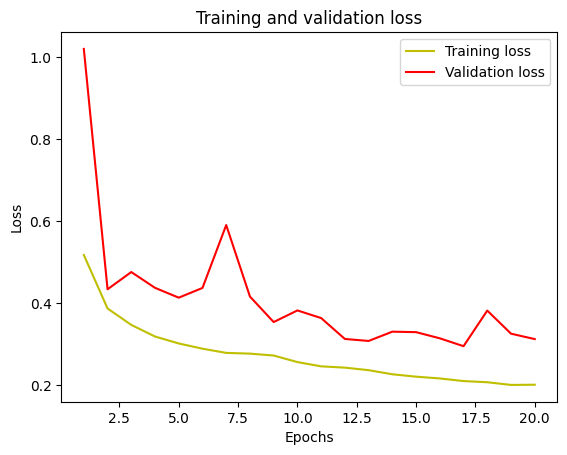

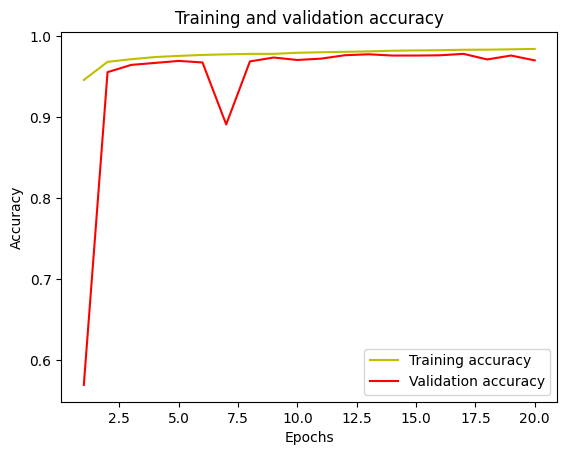

In [21]:
#plot the training and validation IoU and loss at each epoch
import matplotlib.pyplot as plt
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [22]:
model.evaluate(val_img_datagen)

   5042/Unknown 1149s 228ms/step - accuracy: 0.9698 - categorical_accuracy: 0.9698 - dice_coefficient: 0.9698 - iou_score_3d: 0.9410 - loss: 0.3120 - mean_io_u: 0.4008

KeyboardInterrupt: 

In [23]:
# Get a list of all encoder layers
encoder_layers = [layer for layer in model.layers if 'decoder' not in layer.name]

# Freeze all encoder layers first
for layer in encoder_layers:
    layer.trainable = False

# Unfreeze the last 10 encoder layers
for layer in encoder_layers[-20:]:
    layer.trainable = True

# Verify trainable status of all layers
for layer in model.layers:
    print(f"{layer.name}: trainable = {layer.trainable}")

input_layer: trainable = False
Conv1_pad: trainable = False
Conv1: trainable = False
bn_Conv1: trainable = False
Conv1_relu: trainable = False
expanded_conv_depthwise: trainable = False
expanded_conv_depthwise_BN: trainable = False
expanded_conv_depthwise_relu: trainable = False
expanded_conv_project: trainable = False
expanded_conv_project_BN: trainable = False
block_1_expand: trainable = False
block_1_expand_BN: trainable = False
block_1_expand_relu: trainable = False
block_1_pad: trainable = False
block_1_depthwise: trainable = False
block_1_depthwise_BN: trainable = False
block_1_depthwise_relu: trainable = False
block_1_project: trainable = False
block_1_project_BN: trainable = False
block_2_expand: trainable = False
block_2_expand_BN: trainable = False
block_2_expand_relu: trainable = False
block_2_depthwise: trainable = False
block_2_depthwise_BN: trainable = False
block_2_depthwise_relu: trainable = False
block_2_project: trainable = False
block_2_project_BN: trainable = False


In [24]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 128, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_pad           │ (None, 129, 129,  │          0 │ input_layer[0][0] │
│ (ZeroPadding3D)     │ 129, 3)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv3D)      │ (None, 64, 64,    │      2,592 │ Conv1_pad[0][0]   │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        864 │ Conv1_relu[0][0]  │
│ (DepthwiseConv3D)   │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 64, 32)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv3D)            │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 64, 16)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv3D)            │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 64, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding3D)     │ 65, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │      2,592 │ block_1_pad[0][0] │
│ (DepthwiseConv3D)   │ 32, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 32, 96)           │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis

 Total params: 54,469,390 (207.78 MB)

 Trainable params: 18,444,868 (70.36 MB)

 Non-trainable params: 1,305,024 (4.98 MB)

 Optimizer params: 34,719,498 (132.44 MB)

In [25]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
callbacks = [early_stopping]


In [30]:

# Use a lower learning rate for fine-tuning
from tensorflow.keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=1e-5), loss=total_loss,  metrics=['accuracy', 'categorical_accuracy',mean_iou_metric,IOUScore_3D,dice_coefficient])

# Continue training with fine-tuning
history_finetune = model.fit( train_img_datagen,
    steps_per_epoch=steps_per_epoch,                   # Training data generator
    validation_data=val_img_datagen,
    validation_steps=val_steps_per_epoch,
    epochs=100,
    verbose=1,
    callbacks=callbacks

    
    )

Epoch 1/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 518s 1s/step - accuracy: 0.9850 - categorical_accuracy: 0.9850 - dice_coefficient: 0.9850 - iou_score_3d: 0.9708 - loss: 0.1869 - mean_io_u: 0.4961 - val_accuracy: 0.9773 - val_categorical_accuracy: 0.9773 - val_dice_coefficient: 0.9773 - val_iou_score_3d: 0.9566 - val_loss: 0.2768 - val_mean_io_u: 0.4982
Epoch 2/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 54s 421ms/step - accuracy: 0.9854 - categorical_accuracy: 0.9854 - dice_coefficient: 0.9854 - iou_score_3d: 0.9715 - loss: 0.1830 - mean_io_u: 0.4909 - val_accuracy: 0.9767 - val_categorical_accuracy: 0.9767 - val_dice_coefficient: 0.9767 - val_iou_score_3d: 0.9556 - val_loss: 0.2788 - val_mean_io_u: 0.4980
Epoch 3/100
129/129 ━━━━━━━━━━━━━━━━━━━━ 55s 424ms/step - accuracy: 0.9856 - categorical_accuracy: 0.9856 - dice_coefficient: 0.9856 - iou_score_3d: 0.9718 - loss: 0.1810 - mean_io_u: 0.4907 - val_accuracy: 0.9769 - val_categorical_accuracy: 0.9769 - val_dice_coefficient: 0.9770 - val_iou_score_3d: 0.

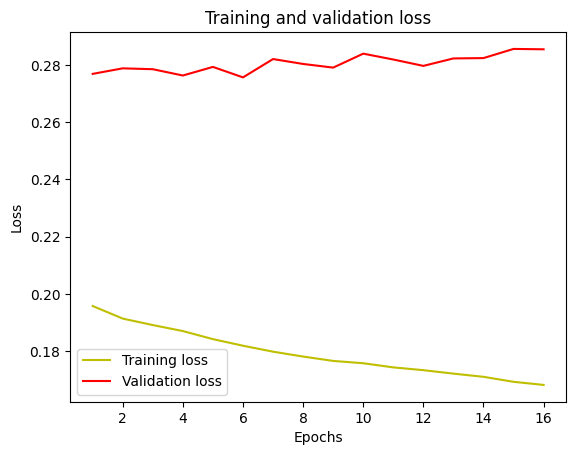

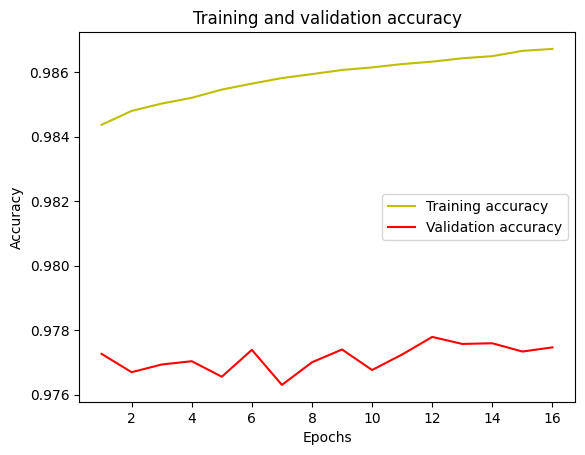

In [31]:
#plot the training and validation IoU and loss at each epoch
import matplotlib.pyplot as plt
loss = history_finetune.history['loss']
val_loss = history_finetune.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history_finetune.history['accuracy']
val_acc = history_finetune.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [32]:
# from keras.metrics import MeanIoU
batch_size=2 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

In [33]:
steps = len(val_img_list) // batch_size
evaluation_results = model.evaluate(test_img_datagen,steps=steps)

print(f'Evaluation results: {evaluation_results}')

43/43 ━━━━━━━━━━━━━━━━━━━━ 11s 248ms/step - accuracy: 0.9792 - categorical_accuracy: 0.9792 - dice_coefficient: 0.9792 - iou_score_3d: 0.9600 - loss: 0.2386 - mean_io_u: 0.4732
Evaluation results: [0.2756146788597107, 0.977388858795166, 0.977388858795166, 0.4979560375213623, 0.9569286108016968, 0.9774271249771118]
